*Title: Analysing Tropospheric Formaldehyde (HCHO) gas in Sri Lanka*

*Author: Benura Wickramanayake 💻*

*Date: 2024-03-25*

In [503]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, DateType, DoubleType, StringType
from pyspark.sql.functions import isnan, sum as Fsum
from pyspark.sql import functions as F
import pyspark_dist_explore as pdx
from pyspark_dist_explore import hist
from pyspark.sql.functions import avg, when

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### PySpark Environment

In [504]:
# create a Spark session
spark = SparkSession.builder.appName("DataPreprocessing").getOrCreate()

## Create Dataframe

Reference - https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_df.html

In [505]:
# Define the schema
schema = StructType([
    StructField("HCHO_reading", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("Current_Date", DateType(), True),
    StructField("Next_Date", DateType(), True)
])

In [506]:
# load data
file_paths = [
    "Dataset\\col_mat_nuw_output.csv",
    "Dataset\\mon_kur_jaf_output.csv",
    "Dataset\\kan_output.csv"
]

In [507]:
# dataframe creation
df = spark.read.csv(file_paths, schema=schema, header=True)

Defined schema of the dataset with data types for each column, load 3 csv files (dataset) into DataFrame  

### Dataset Observations

In [488]:
# data types of columns in the DataFrame
data_types = df.dtypes

for col_name, col_type in data_types:
    print(f"'{col_name}' column data type - '{col_type}'")

'HCHO_reading' column data type - 'double'
'Location' column data type - 'string'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'


In [489]:
# df summary
df_summary = df.describe()
df_summary.show()

+-------+--------------------+-------------------+
|summary|        HCHO_reading|           Location|
+-------+--------------------+-------------------+
|  count|                7916|              12779|
|   mean|1.192609008729181...|               NULL|
| stddev|9.322891110805865E-5|               NULL|
|    min|-3.52473024357239...| Bibile, Monaragala|
|    max|8.997101837438971E-4|Nuwara Eliya Proper|
+-------+--------------------+-------------------+



In [461]:
# DF size
# rows
num_rows = df.count()
# columns
num_cols = len(df.columns)

print(f"Size of the DataFrame: ({num_rows}, {num_cols})")

Size of the DataFrame: (12779, 4)


In [462]:
# see first 50 rows
df.show(50, truncate=False)   #truncate - readability

+----------------------+------------------+------------+----------+
|HCHO_reading          |Location          |Current_Date|Next_Date |
+----------------------+------------------+------------+----------+
|1.919914652467399E-5  |Bibile, Monaragala|2019-01-02  |2019-01-03|
|2.8114479359302837E-5 |Bibile, Monaragala|2019-01-03  |2019-01-04|
|3.747998184385943E-5  |Bibile, Monaragala|2019-01-04  |2019-01-05|
|-1.7982608793453114E-5|Bibile, Monaragala|2019-01-05  |2019-01-06|
|1.4578368961799026E-4 |Bibile, Monaragala|2019-01-06  |2019-01-07|
|2.8285908025465342E-5 |Bibile, Monaragala|2019-01-07  |2019-01-08|
|NULL                  |Bibile, Monaragala|2019-01-08  |2019-01-09|
|1.4208501670509577E-4 |Bibile, Monaragala|2019-01-09  |2019-01-10|
|NULL                  |Bibile, Monaragala|2019-01-10  |2019-01-11|
|2.014587947072581E-5  |Bibile, Monaragala|2019-01-11  |2019-01-12|
|1.5827876632101837E-4 |Bibile, Monaragala|2019-01-12  |2019-01-13|
|NULL                  |Bibile, Monaragala|2019-

In [463]:
# unique values of location column
unique_locations = df.select("Location").distinct()
unique_locations.show()

+-------------------+
|           Location|
+-------------------+
|  Kurunegala Proper|
| Bibile, Monaragala|
|      Jaffna Proper|
|   Deniyaya, Matara|
|     Colombo Proper|
|Nuwara Eliya Proper|
|       Kandy Proper|
+-------------------+



# PreProcessing

## 1. Check NULL & NaN values

In [509]:
# Get # of null values for each locations
# Group by 'Location' and count null values in each group
null_counts = df.groupBy("Location").agg(
    F.sum(F.col("HCHO_reading").isNull().cast("int")).alias("Null_Count")
)

for row in null_counts.collect():
    location = row["Location"]
    null_count = row["Null_Count"]
    print(f"{location} - {null_count} null values")

Kurunegala Proper - 592 null values
Bibile, Monaragala - 694 null values
Jaffna Proper - 365 null values
Deniyaya, Matara - 847 null values
Colombo Proper - 487 null values
Nuwara Eliya Proper - 1085 null values
Kandy Proper - 793 null values


In [510]:
# sum of null value rows for each Location
null_counts.show()

+-------------------+----------+
|           Location|Null_Count|
+-------------------+----------+
|  Kurunegala Proper|       592|
| Bibile, Monaragala|       694|
|      Jaffna Proper|       365|
|   Deniyaya, Matara|       847|
|     Colombo Proper|       487|
|Nuwara Eliya Proper|      1085|
|       Kandy Proper|       793|
+-------------------+----------+



In [511]:
# total # of rows with null values in DF
total_null_rows = df.filter(df.HCHO_reading.isNull()).count()

print("Total number of rows with null values:", total_null_rows)

Total number of rows with null values: 4863


Full dataset has 12779 rows. 4863 rows have NULL values. We cant drop those rows bcz it has around 1/3 of full dataframe. So we should handle those values.

In [512]:
# check null values Column wise
for col in df.columns:
    null_count = df.filter(df[col].isNull()).count()
    print(f"Column: {col}, Null Count: {null_count}")

Column: HCHO_reading, Null Count: 4863
Column: Location, Null Count: 0
Column: Current_Date, Null Count: 0
Column: Next_Date, Null Count: 0


Also only 'HCHO_reading' column has NULL values

### Check NaN values 

In [513]:
# Check NaN values in non-numeric columns
non_numeric_cols = ["Location", "Current_Date", "Next_Date"]

for col in non_numeric_cols:
    nan_count = df.select(Fsum(F.col(col).isNull().cast("int"))).collect()[0][0]
    print(f"Number of NaN values in '{col}' column: {nan_count}")

# Count of NaN values in 'HCHO_reading' column
nan_count_hcho = df.select(Fsum(F.isnan(df["HCHO_reading"]).cast("int"))).collect()[0][0]
print(f"Number of NaN values in 'HCHO_reading' column: {nan_count_hcho}")

Number of NaN values in 'Location' column: 0
Number of NaN values in 'Current_Date' column: 0
Number of NaN values in 'Next_Date' column: 0
Number of NaN values in 'HCHO_reading' column: 0


So there are no any NaN values in the dataset.

We have to handle NULL values.

### Get unique values of each column

In [514]:
for col in df.columns:
    unique_values = df.select(col).distinct().collect()
    
    print(f"Column: {col}")
    for val in unique_values:
        print(val[0])
    print("---------------")

Column: HCHO_reading
9.694880280715724e-05
0.0002193736930364124
-6.385750734361702e-05
6.676890262375307e-05
0.00023581672172941003
0.0001330033250583554
0.00022376243823328678
0.00014415846380457713
4.471236742579997e-05
0.00025864763414889814
4.508168997927766e-05
0.00019078656381855803
0.0002282886546883753
0.00014234945934412017
0.00013770668199936483
0.00025294227253453225
0.0001091543470120435
6.048995265610632e-05
4.597268387000088e-05
8.415824387636693e-05
4.568596580117736e-05
0.0002163863036346548
5.4732213064223596e-05
6.928370223774921e-05
0.00013013847716940348
0.00018641590767590403
6.107487274713773e-05
0.00011186406323859304
0.00023167759544939152
0.00011737181324750144
0.00015482738489700523
0.00017165291269917717
5.044614104756958e-05
8.510380215899425e-05
0.0003417715575369086
0.00012375404956124178
0.00017683619048078177
9.049237826246958e-06
0.00011498307620892104
0.00031371571363920345
7.681634949705504e-05
0.00016171075016852758
6.794723518060958e-05
1.952057598

Some values are in Scientific notation.

## 2. Handle Scientific Notation 

Reference - https://spark.apache.org/docs/3.1.2/api/python/reference/api/pyspark.sql.functions.format_number.html , https://stackoverflow.com/questions/40206592/how-to-turn-off-scientific-notation-in-pyspark

In [446]:
# format HCHO_reading values with 10 decimal places
#df = df.withColumn("HCHO_reading_converted", F.format_number(F.col("HCHO_reading"), 15))

In [447]:
#df.show(10, truncate=False)

+----------------------+------------------+------------+----------+----------------------+
|HCHO_reading          |Location          |Current_Date|Next_Date |HCHO_reading_converted|
+----------------------+------------------+------------+----------+----------------------+
|1.919914652467399E-5  |Bibile, Monaragala|2019-01-02  |2019-01-03|0.000019199146525     |
|2.8114479359302837E-5 |Bibile, Monaragala|2019-01-03  |2019-01-04|0.000028114479359     |
|3.747998184385943E-5  |Bibile, Monaragala|2019-01-04  |2019-01-05|0.000037479981844     |
|-1.7982608793453114E-5|Bibile, Monaragala|2019-01-05  |2019-01-06|-0.000017982608793    |
|1.4578368961799026E-4 |Bibile, Monaragala|2019-01-06  |2019-01-07|0.000145783689618     |
|2.8285908025465342E-5 |Bibile, Monaragala|2019-01-07  |2019-01-08|0.000028285908025     |
|NULL                  |Bibile, Monaragala|2019-01-08  |2019-01-09|NULL                  |
|1.4208501670509577E-4 |Bibile, Monaragala|2019-01-09  |2019-01-10|0.000142085016705     |

In [448]:
# data types of columns in the DataFrame
#data_types = df.dtypes

#for col_name, col_type in data_types:
    #print(f"'{col_name}' column data type - '{col_type}'")

'HCHO_reading' column data type - 'double'
'Location' column data type - 'string'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'
'HCHO_reading_converted' column data type - 'string'


In [450]:
# Cast the column to double data type
#df = df.withColumn("HCHO_reading_converted", df["HCHO_reading_converted"].cast("double"))

In [451]:
# data types of columns in the DataFrame
#data_types = df.dtypes

#for col_name, col_type in data_types:
    #print(f"'{col_name}' column data type - '{col_type}'")

'HCHO_reading' column data type - 'double'
'Location' column data type - 'string'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'
'HCHO_reading_converted' column data type - 'double'


In [452]:
# replace new column with "HCHO_reading" name
#df = df.drop("HCHO_reading").withColumnRenamed("HCHO_reading_converted", "HCHO_reading")

In [453]:
#df.show(10, truncate=False)

+------------------+------------+----------+----------------+
|Location          |Current_Date|Next_Date |HCHO_reading    |
+------------------+------------+----------+----------------+
|Bibile, Monaragala|2019-01-02  |2019-01-03|1.9199146525E-5 |
|Bibile, Monaragala|2019-01-03  |2019-01-04|2.8114479359E-5 |
|Bibile, Monaragala|2019-01-04  |2019-01-05|3.7479981844E-5 |
|Bibile, Monaragala|2019-01-05  |2019-01-06|-1.7982608793E-5|
|Bibile, Monaragala|2019-01-06  |2019-01-07|1.45783689618E-4|
|Bibile, Monaragala|2019-01-07  |2019-01-08|2.8285908025E-5 |
|Bibile, Monaragala|2019-01-08  |2019-01-09|NULL            |
|Bibile, Monaragala|2019-01-09  |2019-01-10|1.42085016705E-4|
|Bibile, Monaragala|2019-01-10  |2019-01-11|NULL            |
|Bibile, Monaragala|2019-01-11  |2019-01-12|2.0145879471E-5 |
+------------------+------------+----------+----------------+
only showing top 10 rows



In [427]:
# data types of columns in the DataFrame
#data_types = df.dtypes

#for col_name, col_type in data_types:
    #print(f"'{col_name}' column data type - '{col_type}'")

'HCHO_reading' column data type - 'double'
'Location' column data type - 'string'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'


## 2. Handle NULL values

Reference - https://pandas.pydata.org/docs/user_guide/missing_data.html , https://www.educba.com/pyspark-left-join/

### Decided to handle null values based on the Location. Fill NULL values with the mean HCHO reading for each location.

In [515]:
# calculate mean HCHO reading for each location
mean_hcho = df.groupBy("Location").agg(avg("HCHO_reading").alias("Mean_HCHO"))

mean_hcho.show(truncate=False)

+-------------------+---------------------+
|Location           |Mean_HCHO            |
+-------------------+---------------------+
|Kurunegala Proper  |1.340202702666862E-4 |
|Bibile, Monaragala |1.2643137974120453E-4|
|Jaffna Proper      |1.088086650369041E-4 |
|Deniyaya, Matara   |9.165608034246397E-5 |
|Colombo Proper     |1.5854269566699302E-4|
|Nuwara Eliya Proper|8.792586073767327E-5 |
|Kandy Proper       |1.0630856146355229E-4|
+-------------------+---------------------+



In [516]:
# join mean_hcho DataFrame with original DataFrame for filling null values
df = df.join(mean_hcho, "Location", "left").withColumn(
    "HCHO_reading",
    when(F.col("HCHO_reading").isNull(), mean_hcho["Mean_HCHO"]).otherwise(F.col("HCHO_reading"))
)

In [517]:
df.show()

+------------------+--------------------+------------+----------+--------------------+
|          Location|        HCHO_reading|Current_Date| Next_Date|           Mean_HCHO|
+------------------+--------------------+------------+----------+--------------------+
|Bibile, Monaragala|1.919914652467399E-5|  2019-01-02|2019-01-03|1.264313797412045...|
|Bibile, Monaragala|2.811447935930283...|  2019-01-03|2019-01-04|1.264313797412045...|
|Bibile, Monaragala|3.747998184385943E-5|  2019-01-04|2019-01-05|1.264313797412045...|
|Bibile, Monaragala|-1.79826087934531...|  2019-01-05|2019-01-06|1.264313797412045...|
|Bibile, Monaragala|1.457836896179902...|  2019-01-06|2019-01-07|1.264313797412045...|
|Bibile, Monaragala|2.828590802546534...|  2019-01-07|2019-01-08|1.264313797412045...|
|Bibile, Monaragala|1.264313797412045...|  2019-01-08|2019-01-09|1.264313797412045...|
|Bibile, Monaragala|1.420850167050957...|  2019-01-09|2019-01-10|1.264313797412045...|
|Bibile, Monaragala|1.264313797412045...|  

In [518]:
# data types of columns in the DataFrame
data_types = df.dtypes

for col_name, col_type in data_types:
    print(f"'{col_name}' column data type - '{col_type}'")

'Location' column data type - 'string'
'HCHO_reading' column data type - 'double'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'
'Mean_HCHO' column data type - 'double'


In [519]:
# Drop the "Mean_HCHO" column
df = df.drop("Mean_HCHO")

df.show()

+------------------+--------------------+------------+----------+
|          Location|        HCHO_reading|Current_Date| Next_Date|
+------------------+--------------------+------------+----------+
|Bibile, Monaragala|1.919914652467399E-5|  2019-01-02|2019-01-03|
|Bibile, Monaragala|2.811447935930283...|  2019-01-03|2019-01-04|
|Bibile, Monaragala|3.747998184385943E-5|  2019-01-04|2019-01-05|
|Bibile, Monaragala|-1.79826087934531...|  2019-01-05|2019-01-06|
|Bibile, Monaragala|1.457836896179902...|  2019-01-06|2019-01-07|
|Bibile, Monaragala|2.828590802546534...|  2019-01-07|2019-01-08|
|Bibile, Monaragala|1.264313797412045...|  2019-01-08|2019-01-09|
|Bibile, Monaragala|1.420850167050957...|  2019-01-09|2019-01-10|
|Bibile, Monaragala|1.264313797412045...|  2019-01-10|2019-01-11|
|Bibile, Monaragala|2.014587947072581E-5|  2019-01-11|2019-01-12|
|Bibile, Monaragala|1.582787663210183...|  2019-01-12|2019-01-13|
|Bibile, Monaragala|1.264313797412045...|  2019-01-13|2019-01-14|
|Bibile, M

In [520]:
# check null values Column wise
for col in df.columns:
    null_count = df.filter(df[col].isNull()).count()
    print(f"Column: {col}, Null Count: {null_count}")

Column: Location, Null Count: 0
Column: HCHO_reading, Null Count: 0
Column: Current_Date, Null Count: 0
Column: Next_Date, Null Count: 0


In [521]:
# check data types of columns in the DataFrame
data_types = df.dtypes

for col_name, col_type in data_types:
    print(f"'{col_name}' column data type - '{col_type}'")

'Location' column data type - 'string'
'HCHO_reading' column data type - 'double'
'Current_Date' column data type - 'date'
'Next_Date' column data type - 'date'


## 3. Save DataFrame

Reference - https://spark.apache.org/docs/latest/sql-data-sources-load-save-functions.html,https://stackoverflow.com/questions/50958721/convert-a-spark-dataframe-to-pandas-df, https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.shuffle.html  

### Convert PySpark DataFrame to Pandas DataFrame

In [527]:
# PySpark df to pandas df
pandas_df = df.toPandas()

# onvert data types in pandas df
pandas_df['Location'] = pandas_df['Location'].astype(str)
pandas_df['HCHO_reading'] = pandas_df['HCHO_reading'].astype(float)
pandas_df['Current_Date'] = pd.to_datetime(pandas_df['Current_Date'])
pandas_df['Next_Date'] = pd.to_datetime(pandas_df['Next_Date'])

# save pandas df 
csv_file_path = "DataFrame/pandas_df.csv"
pandas_df.to_csv(csv_file_path, index=False)

In [528]:
pandas_df.head(30)

,Location,HCHO_reading,Current_Date,Next_Date
0,"Bibile, Monaragala",0.000019,2019-01-02,2019-01-03
1,"Bibile, Monaragala",0.000028,2019-01-03,2019-01-04
2,"Bibile, Monaragala",0.000037,2019-01-04,2019-01-05
3,"Bibile, Monaragala",-0.000018,2019-01-05,2019-01-06
4,"Bibile, Monaragala",0.000146,2019-01-06,2019-01-07
5,"Bibile, Monaragala",0.000028,2019-01-07,2019-01-08
6,"Bibile, Monaragala",0.000126,2019-01-08,2019-01-09
7,"Bibile, Monaragala",0.000142,2019-01-09,2019-01-10
8,"Bibile, Monaragala",0.000126,2019-01-10,2019-01-11
9,"Bibile, Monaragala",0.000020,2019-01-11,2019-01-12


In [529]:
pandas_df.dtypes

Location                object
HCHO_reading           float64
Current_Date    datetime64[ns]
Next_Date       datetime64[ns]
dtype: object

## 5. Handle Duplicates

In [530]:
# count occurrences of each unique row
duplicate_counts = df.groupBy([col for col in df.columns]).count()

# rows with counts greater than 1
duplicate_counts = duplicate_counts.filter(F.col("count") > 1)

total_duplicates = duplicate_counts.count()

print(f"Total number of duplicate data points: {total_duplicates}")

Total number of duplicate data points: 0


So there are no any duplicate data points.

## 6. Handle Outliers

Reference - https://www.machinelearningplus.com/pyspark/pyspark-outlier-detection-and-treatment/

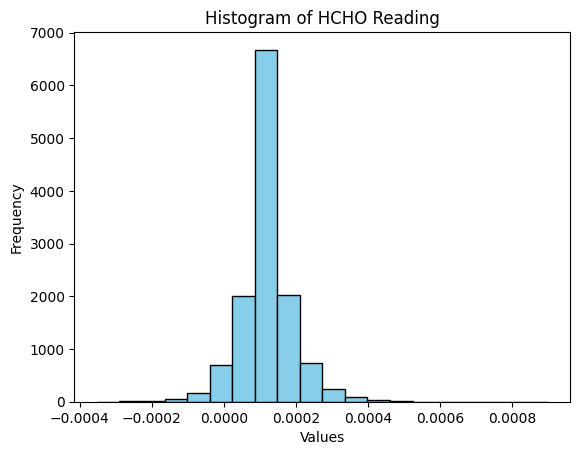

In [531]:
# extract values from the pandas DataFrame column
column_values = pandas_df['HCHO_reading']

plt.hist(column_values, bins=20, color='skyblue', edgecolor='black')

# labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of HCHO Reading')

# plot
plt.show()


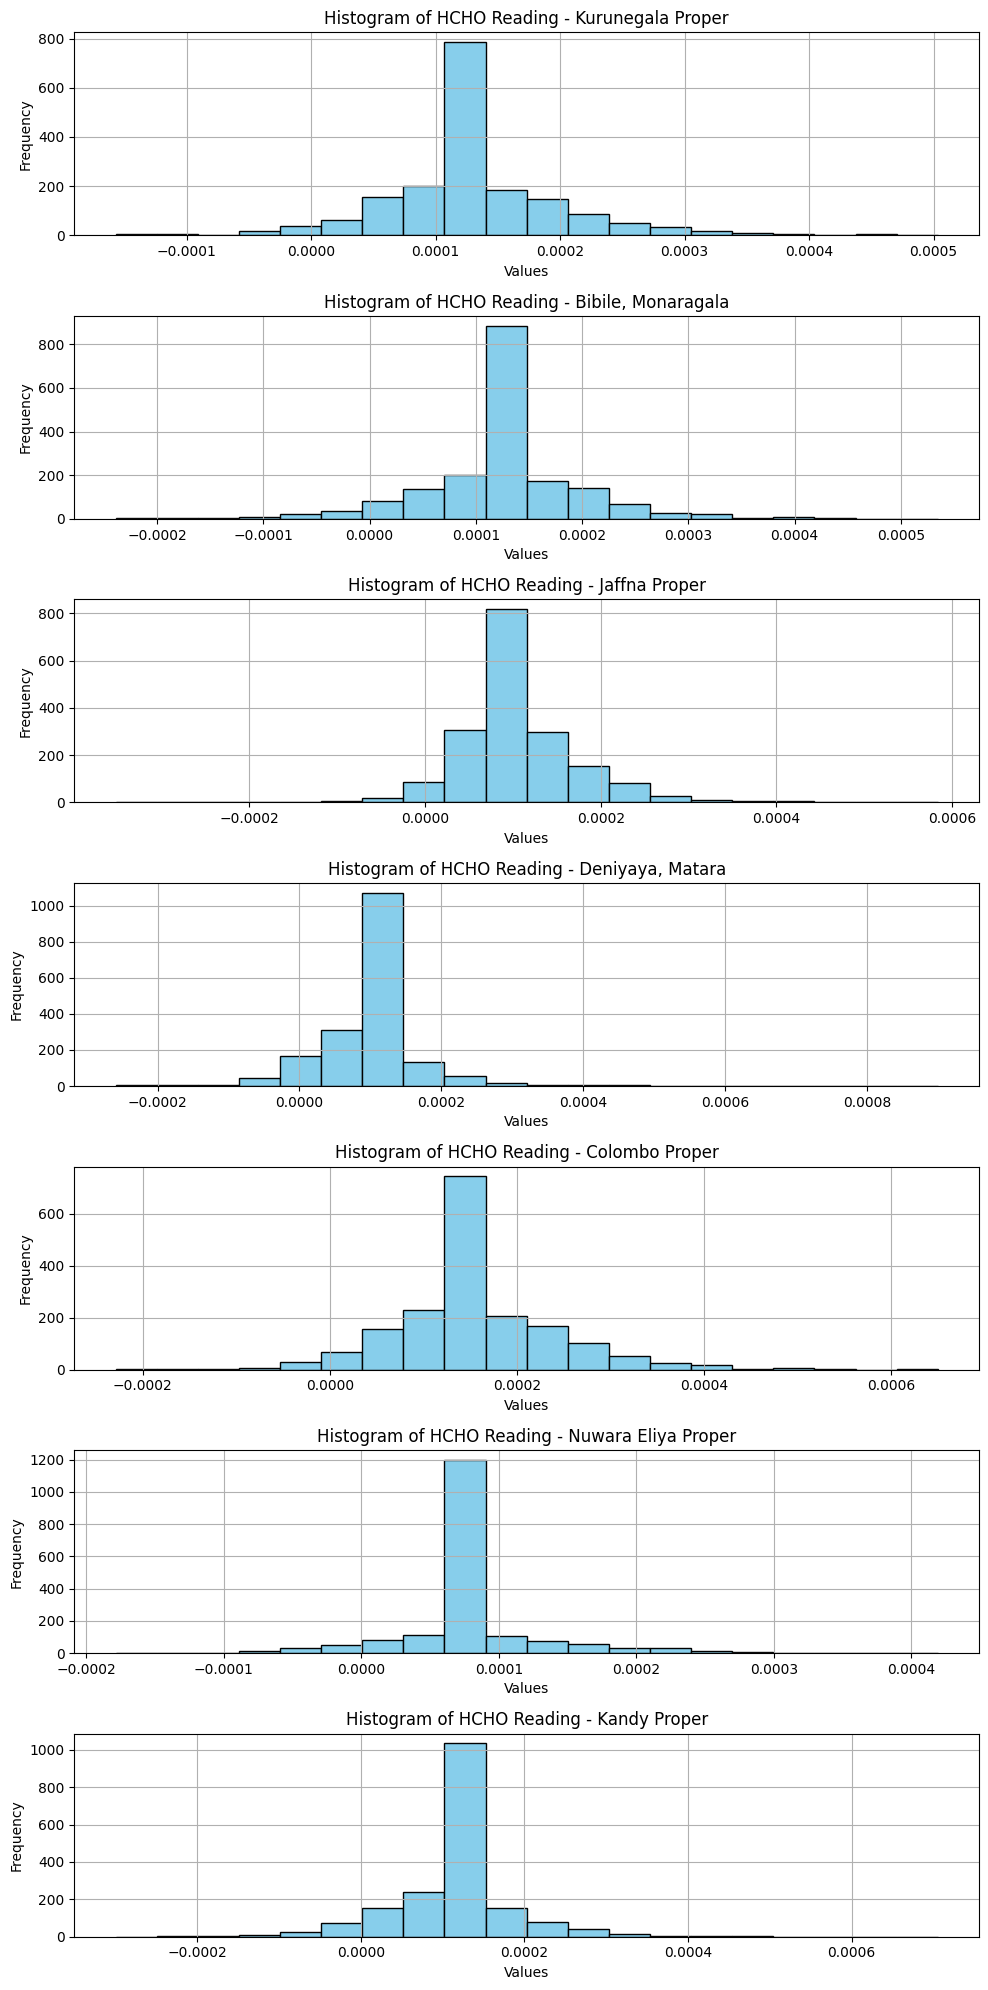

In [532]:
# List of locations for which you want to plot histograms
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# Create subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# Plot histograms for each location
for i, location in enumerate(locations):
    # Filter DataFrame for the current location
    location_df = pandas_df[pandas_df['Location'] == location]
    
    # Extract values from the filtered DataFrame
    column_values = location_df['HCHO_reading']
    
    # Plot histogram for the current location
    axs[i].hist(column_values, bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of HCHO Reading - {location}')
    axs[i].set_xlabel('Values')
    axs[i].set_ylabel('Frequency')
    axs[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

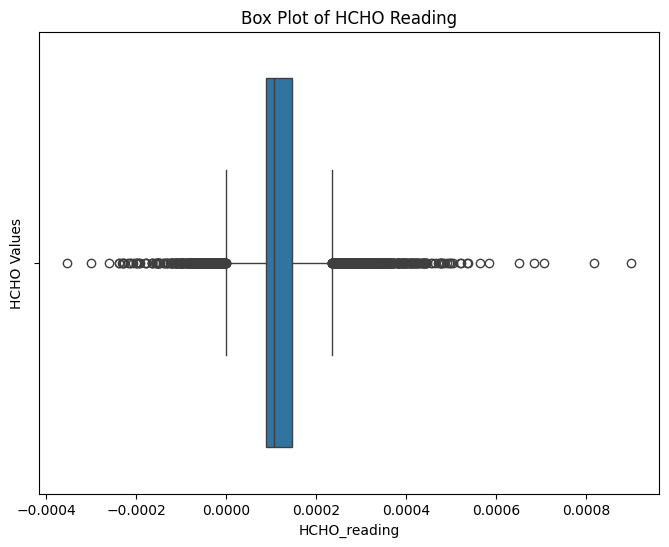

In [533]:
# Extract the values from the DataFrame column
column_values = pandas_df['HCHO_reading']

# Set up the figure and axes
plt.figure(figsize=(8, 6))

# Plot the box plot
sns.boxplot(x=column_values)

# Add labels and title
plt.ylabel('HCHO Values')
plt.title('Box Plot of HCHO Reading')

# Show the plot
plt.show()

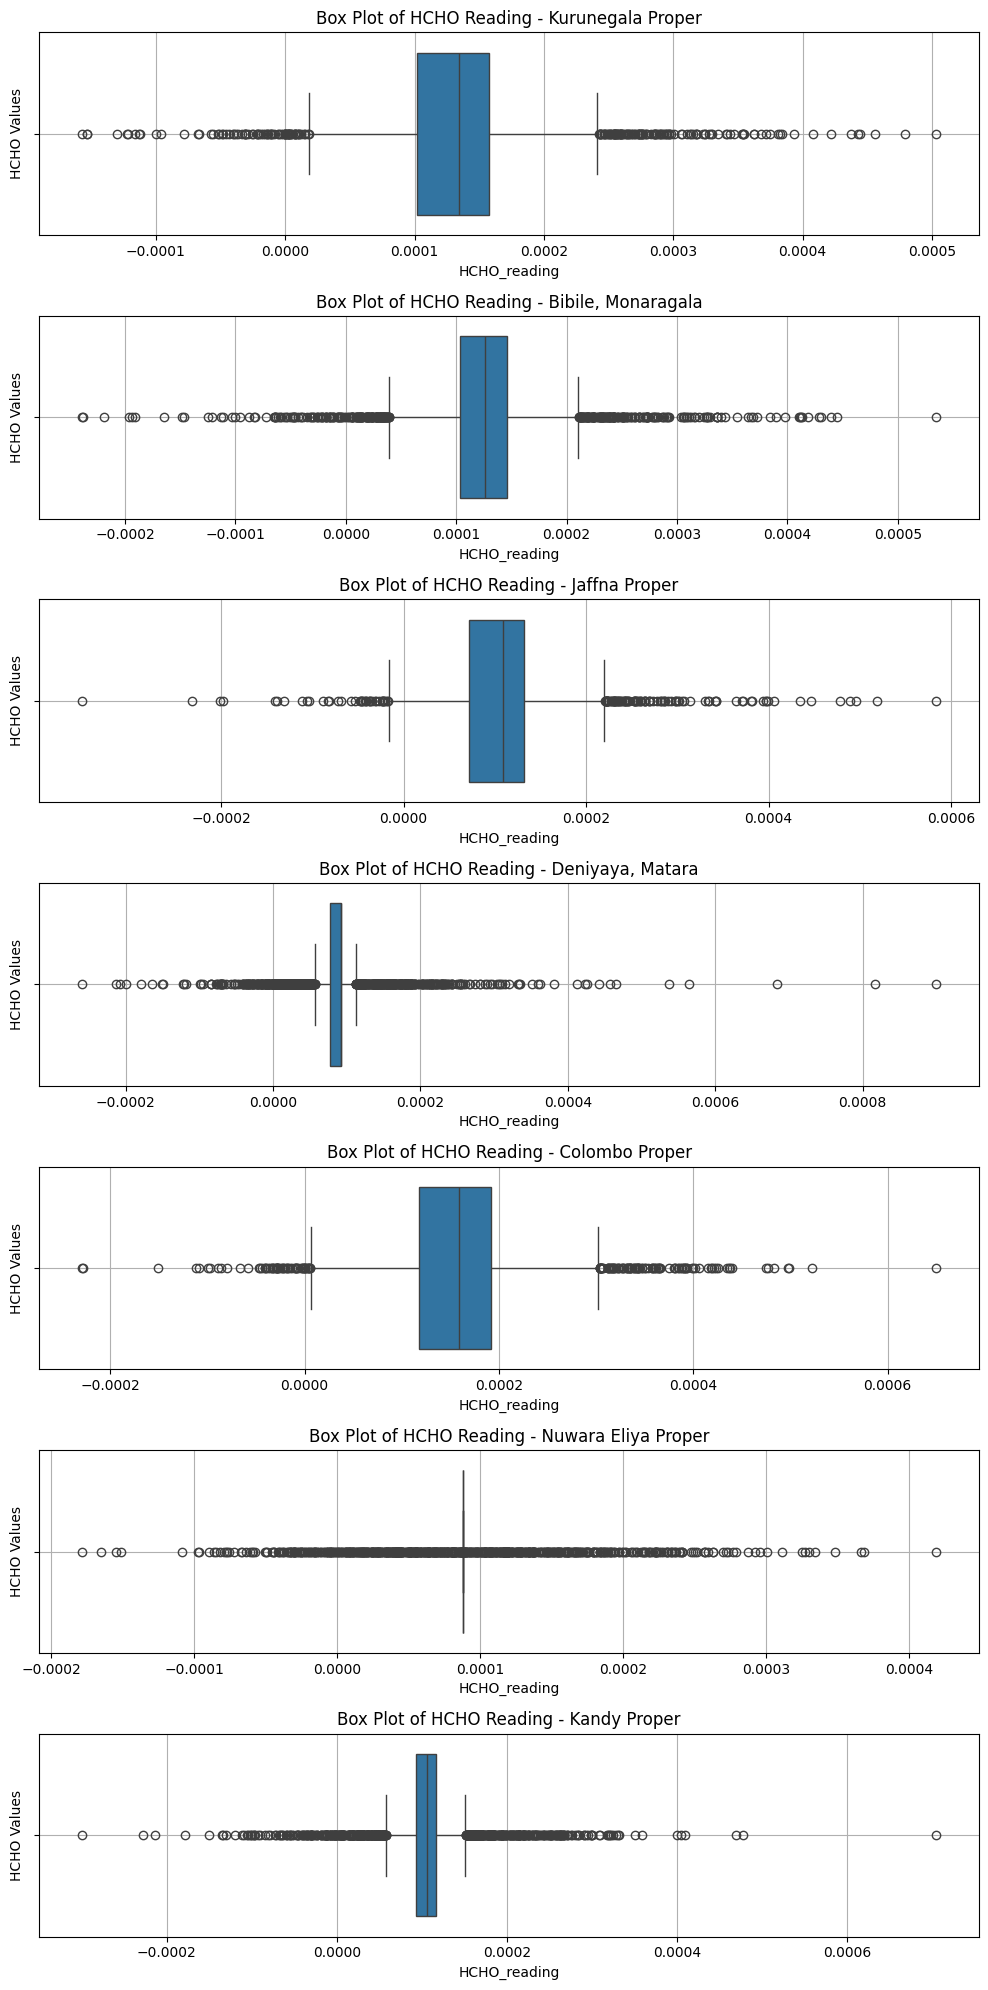

In [534]:
# List of locations for which you want to plot box plots
locations = ['Kurunegala Proper', 'Bibile, Monaragala', 'Jaffna Proper', 'Deniyaya, Matara', 
             'Colombo Proper', 'Nuwara Eliya Proper', 'Kandy Proper']

# Create subplots for each location
fig, axs = plt.subplots(len(locations), figsize=(10, 20))

# Plot box plots for each location
for i, location in enumerate(locations):
    # Filter DataFrame for the current location
    location_df = pandas_df[pandas_df['Location'] == location]
    
    # Extract values from the filtered DataFrame
    column_values = location_df['HCHO_reading']
    
    # Plot box plot for the current location
    sns.boxplot(x=column_values, ax=axs[i])
    axs[i].set_title(f'Box Plot of HCHO Reading - {location}')
    axs[i].set_ylabel('HCHO Values')
    axs[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()